In [1]:
CARDIAC_COMA_REPO = "/home/rodrigo/CISTIB/repos/CardiacCOMA/"

In [2]:
import mlflow
import os, sys

import torch
import torch.nn.functional as F

import os; os.chdir(CARDIAC_COMA_REPO)
from config.load_config import load_yaml_config, to_dict

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import Image
from mlflow.tracking import MlflowClient

import pickle as pkl
import pytorch_lightning as pl

from argparse import Namespace
import matplotlib.pyplot as plt

#import surgeon_pytorch
#from surgeon_pytorch import Inspect, get_layers

import numpy as np
import pandas as pd
from IPython import embed
sys.path.insert(0, '..')

import model.Model3D
from utils.helpers import get_coma_args, get_lightning_module, get_datamodule
from copy import deepcopy
from pprint import pprint

from copy import deepcopy
from typing import List

In [3]:
from mlflow_helpers import \
    list_artifacts,\
    get_significant_loci,\
    get_metrics_cols, \
    get_params_cols, \
    get_runs_df, \
    get_good_runs,\
    summarize_loci_across_runs,\
    get_model_pretrained_weights

In [4]:
TRACKING_URI = f"file://{CARDIAC_COMA_REPO}/mlruns"
mlflow.set_tracking_uri(TRACKING_URI)

In [5]:
client = MlflowClient()

### Retrieve cardiac indices

In [6]:
timeframe = "1".zfill(3)
datafolder = "data/cardio/cardiac_indices"

In [7]:
df = pd.concat([pd.read_csv(f"{datafolder}/G{i}/LVRV_time{timeframe}.csv", index_col="case_id") for i in range(1,5)])

In [8]:
df

,LVEDV (mL),LVM (g),RVEDV (mL)
case_id,,,
1575594,169.515362,96.505318,203.963810
1982723,113.870137,62.877573,121.807408
1070966,131.174275,72.171091,137.144004
1851234,156.977255,92.898278,178.114947
1752613,119.700546,94.632015,141.645332
...,...,...,...
4542967,151.443686,89.504582,154.916932
4199605,147.178375,107.944423,144.030801
4934524,170.701413,102.833356,179.698969


### Compute sphericity

In [9]:
import scipy
import math
import pandas as pd
import os
import shlex
from subprocess import check_output

from scipy.spatial import ConvexHull

import numpy as np
import pickle as pkl

import pyvista as pv
from ipywidgets import interact, interactive, fixed, interact_manual

In [88]:
# meshes = pkl.load(open("data/cardio/LV_meshes_at_ED_35k.pkl", "rb"))
# convhull = {}
# for i, (id, mesh) in enumerate(meshes.items()):
#     if i % 1000 == 0:
#         print(i)
#     convhull[id] = ConvexHull(mesh)

In [11]:
def sphericity_index(convex_hull):
    return((36 * math.pi * convex_hull.volume**2)**(1./3) / convex_hull.area)

In [12]:
sph_df = pd.read_csv("data/cardio/sphericity.csv")

In [13]:
df.index = df.index.astype(str)
sph_df = sph_df.set_index("id")
sph_df.index = sph_df.index.astype(str)

In [14]:
cardiac_indices_df = df.merge(sph_df, left_index=True, right_index=True)

In [15]:
cardiac_indices_df

,LVEDV (mL),LVM (g),RVEDV (mL),LVSph
1000215,109.544212,70.061720,118.586674,0.945627
1000336,123.185025,73.821846,121.557099,0.935885
1000363,172.502476,136.292264,188.630958,0.939892
1000380,179.841796,107.327191,200.192059,0.943578
1000407,140.523982,85.071837,150.744855,0.948078
...,...,...,...,...
4999331,119.871666,77.005132,128.292674,0.951050
4999373,143.356482,83.120939,137.664470,0.946512
4999543,123.396442,84.933799,139.303552,0.955392
4999719,137.733007,84.338143,138.312118,0.950610


In [18]:
def experiment_selection_widget():
    options = [exp.name for exp in mlflow.list_experiments()]

    experiment_w = widgets.Select(
      options=options,
      value="Cardiac - ED"
    )
    
    return experiment_w

exp_w = experiment_selection_widget()

@interact
def get_runs(exp_name=exp_w):  
  try:
    exp_id = mlflow.get_experiment_by_name(exp_name).experiment_id
    runs_df = get_runs_df(exp_name=exp_name, only_finished=True)
    metrics, params = get_metrics_cols(runs_df), get_params_cols(runs_df)  
    # display(runs_df.loc[:, [*metrics, *params]].drop("params.platform", axis=1).head(10))
    return runs_df
  except:
    pass

interactive(children=(Select(description='exp_name', options=('Cardiac - ED', 'Default'), value='Cardiac - ED'…

In [43]:
runs_df = get_runs_df(exp_name=exp_w.value, only_finished=True)

In [44]:
z_paths = runs_df.reset_index().apply(
    lambda row: ((row.experiment_id, row.run_id), row.artifact_uri.replace("file://", "") + f'''/output/z_adj_{row.experiment_id}_{row.run_id}.tsv'''), axis=1
)
z_paths = dict(z_paths.values.tolist())

In [45]:
z_dfs = {}

for run_id, z_path in z_paths.items():
    try:
        z_dfs[run_id] = pd.read_csv(z_path, sep="\t").set_index("ID")
    except FileNotFoundError:
        pass

In [39]:
def change_col_names(exper_id, run_id, kk):
    kk.columns = [f"{exper_id}_{run_id[:5]}_{col}" for col in kk.columns]
    return kk

In [47]:
z_dfs_renamed = [change_col_names(expid, runid, z_df) for (expid, runid), z_df in z_dfs.items()]

In [105]:
z_all_df = pd.concat(z_dfs_renamed, axis=1)

In [57]:
z_corr_df = z_all_df.corr().abs()

# Correlation between latent variables

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
corr_lst = np.triu(z_corr_df.to_numpy()).flatten()

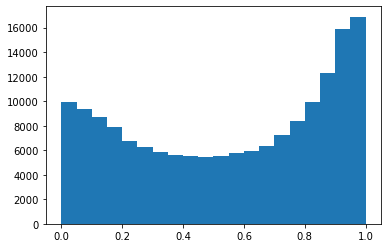

In [87]:
plt.hist(corr_lst[~(corr_lst == 1.) & ~(corr_lst == 0.)], bins=20);

In [106]:
z_all_df = z_all_df.set_index(z_all_df.index.astype(str))

In [115]:
z_all_df.index

Index(['2471198', '1746709', '2008596', '4917788', '1780889', '4132998',
       '1945485', '3447737', '1430120', '2862266',
       ...
       '3661561', '2760723', '4078882', '4149767', '3582825', '4485380',
       '3878790', '1703522', '2034360', '4424098'],
      dtype='object', name='ID', length=31620)

In [150]:
common_subjects = list(set(cardiac_indices_df.drop_duplicates().index).intersection(set(z_all_df.drop_duplicates().index)))

In [168]:
len(common_subjects)

31610

In [170]:
ccii = cardiac_indices_df.loc[sorted(common_subjects)].drop_duplicates()

In [180]:
zz.shape

(31610, 576)

In [186]:
zz["1_e6490_z000"].corr(ccii.LVSph)

0.012538214408424665

In [178]:
ccii.corrwith(zz[0], axis=1)

1000336   NaN
1000363   NaN
1000380   NaN
1000407   NaN
1000739   NaN
           ..
4999331   NaN
4999373   NaN
4999543   NaN
4999719   NaN
4999878   NaN
Length: 31610, dtype: float64

In [164]:
zz = z_all_df.loc[sorted(common_subjects)].drop_duplicates()

In [197]:
ccii.isna().count()

LVEDV (mL)    31610
LVM (g)       31610
RVEDV (mL)    31610
LVSph         31610
dtype: int64

In [222]:
ccii.to_csv("lvedv_lvm_rvedv_lvsph.csv", index=True, index_label="ID")

In [209]:
corr_matrix = pd.concat([zz, ccii], axis=1).corr() #.index.str.startswith("LV")

In [220]:
z_corr = zz.corr()

In [215]:
corr_z_vs_indices = corr_matrix[ccii.columns]

In [224]:
corr_z_vs_indices.to_csv("data/cardio/corr_z_vs_indices.csv", index=True, index_label="phenotype")

In [120]:
len([ind for ind in cardiac_indices_df.index if ind in z_all_df.index])

32009

In [95]:
cardiac_indices_df.index

Index(['1000215', '1000336', '1000363', '1000380', '1000407', '1000434',
       '1000590', '1000739', '1000892', '1001145',
       ...
       '4998334', '4998438', '4998720', '4999081', '4999177', '4999331',
       '4999373', '4999543', '4999719', '4999878'],
      dtype='object', length=36047)